In [1]:
import numpy as np
from utils import es_utils as es
from utils import itd_utils as itd
from utils import prob_utils as prob

import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

from python_speech_features import logfbank

from scipy.io import wavfile
import re
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import gammamix

from collections import OrderedDict
import itertools
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import os
import tables

import keras
import keras.backend as K


/home/enea/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Some routines

In [6]:
def remove_trigger(timestamps, addresses):
    dx = 0.000001
    idx =  np.argmax(np.diff(timestamps)/dx)
    return timestamps[idx + 1:], addresses[idx + 1:]

def wind_sp(ts, ch, w=0.001):
    ts_int = (ts // w).astype('int32')
    if len(ts_int) < 1:
        ts_int = np.array([0,0])

    A = np.zeros((np.max(ts_int) + 3000, 64))
    A += np.abs(np.random.randn(A.shape[0], A.shape[1]))

    for _t, _c in zip(ts_int, ch):
        A[_t, _c] += 100
    
#     A = np.minimum(A, np.ones_like(A))
    # returning [ch, T]
    return A.T

def exp_feat(A, win=0.05, tpe='lap', l=300):
    if tpe == 'exp':
        t = np.arange(0, win, 0.001)
        b = np.exp(-l * t)
    elif tpe == 'lap':
        t = np.arange(-win, win, 0.001)
        b = np.exp(-l * np.abs(t))
        
    b /= np.linalg.norm(b)
    AA = np.array([np.convolve(_a, b, 'same') for _a in A])
    return AA

def smear_fr(A, win=3, l=10):
#     t = np.arange(-win, win, 1)
#     b = np.exp(-l * np.abs(t))
#     b = np.concatenate([np.arange(win), np.arange(win)[::-1]])
#     A = np.array([np.convolve(_a, b, 'same') for _a in A.T])
    A = gaussian_filter(A, 1)
    return A

def simple_low_pass(X, win=60, shift=40):
    n_win = (X.shape[0] - win) // shift
    XX = np.zeros((n_win, X.shape[1]))
    for i in range(0, n_win):
        XX[i] = np.sum(X[i * shift: (i + 1) * shift] , 0) / win
    return XX

def spike_features(T1, C1):
    A = wind_sp(np.array(T1), np.array(C1).astype('int32'))
    AA = exp_feat(A, win=0.05, l=30, tpe='lap')
    AAA = smear_fr(AA, win=3)
    AAAA = simple_low_pass(AAA.T).T
    
    return np.log10(AAAA + 1e-9)

def get_ctx_win(X, ctx=5, shift=1):
    n_win = (X.shape[1] - ctx * 2) // shift
    X_re = np.array([X[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
    return X_re

def find_local_maxima(x, win=5):
    to_pad = win // 2
    x = np.pad(x, (to_pad,to_pad), 'constant', constant_values=(0, 0))
    idx = []
    for i in range(to_pad, len(x) - to_pad):
        if np.argmax(x[i - to_pad: i + to_pad]) == to_pad:
            idx.append(i - to_pad)
    return np.array(idx)
def correct_pos(pos):
    if pos == 0:
        pos = 1
    if pos == 18:
        pos = 17
    return pos

# SPS

In [3]:
def sps(filename, sigma=20, priors='priors_long_hv_corrected_all.npy', correction_dict='correction_dict.pkl', channels=np.arange(64)):
    
    # load priors
    priors = np.load(priors)
    dict_c = pkl.load(open(correction_dict, 'r'))
    itd_dict = itd.get_itd_dict(max_itd, num_bins)*1e6
    
    # load / trigger / decode
    timestamps, addresses = es.loadaerdat(filename)
    timestamps, addresses = remove_trigger(timestamps, addresses)
    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    # load wavs
    spk1, spk2, _ = re.compile('[0-9]+').split(all_train[IDX])
    _, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)

    fs, w1 = wavfile.read(basedir + 'wavs/train/' + gts1[IDX].replace('\\', '/') + '.wav')
    fs, w2 = wavfile.read(basedir + 'wavs/train/' + gts2[IDX].replace('\\', '/') + '.wav')
    
    # get itd and fix them
    _aa = {}
    idx_dict = {}
    for kk in channels:
        indices_channels = np.isin(channel_id, np.array([kk]))
        if kk in dict_c:
            try:
                _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                     verbose=False, max_itd=max_itd)
                idx_dict[kk] = _itd_idx
                _mu = dict_c[kk]['mu']
                _corr = (_itds - _mu)  # / dict_c[kk]['std'] * dict_c[19]['std']
                _aa[kk] = _corr
            except Exception as e:
                pass
    
    # get probabilities
    index_angles = np.vstack([np.arange(19), np.arange(0, 190, 10)]).T

    num_angles = len(priors)
    initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
    transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
    itd_dict = itd.get_itd_dict(max_itd, num_bins) # array holding the mean values of all itd bins
    arg = {}
    for k, _a in _aa.iteritems():
        estimates, argmax_estimates = prob.estimate(_a, initial_estimate, transition_probabilities, itd_dict, priors)
        arg[k] = argmax_estimates
        
    amax = np.array(list(itertools.chain.from_iterable([v for _, v in arg.iteritems()])))
    
    # get separated spikes
    T = []
    C = []
    for p in [pos1, pos2]:
        T1 = []
        C1 = []
        for ch in idx_dict.keys():
#             d = np.where(np.array(idx_dict.keys()) == ch)[0][0]

            
            t = (timestamps[channel_id == ch])[idx_dict[ch][arg[ch] == p]]
            T1.extend(t)
            C1.extend(np.ones_like(t) * ch)
        T.append(T1)
        C.append(C1)
    
    return T, C, w1, w2, fs, amax
    

# Some data preparation

In [4]:
basedir = '/Data/DATASETS/CAESAR_TIDIGITS/'

num_bins = 80
max_itd = 800e-6
num_channels = 64

with open(basedir + 'log_train.txt') as t:
    all_angles = [x for x in t.readlines()]

with open(basedir + 'log_test.txt') as t:
    all_angles_test = [x for x in t.readlines()]

with open('train_set.txt') as t:
    all_train = [line.split(' ')[4].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    gts1 = [line.split(' ')[0].strip() for line in t.readlines()]
with open('train_set.txt') as t:
    gts2 = [line.split(' ')[1].strip() for line in t.readlines()]
    
with open('test_set.txt') as t:
    all_test = [line.split(' ')[4].strip() for line in t.readlines()]
with open('test_set.txt') as t:
    gts1_test = [line.split(' ')[0].strip() for line in t.readlines()]
with open('test_set.txt') as t:
    gts2_test = [line.split(' ')[1].strip() for line in t.readlines()]

# Check priors

(19, 80)


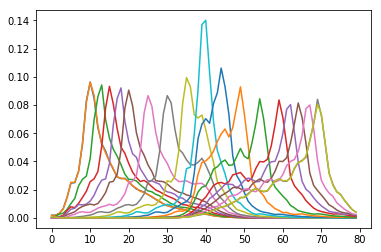

In [5]:
priors = np.load('priors_long_hv_corrected_all.npy')
dict_c = pkl.load(open('correction_dict.pkl', 'r'))
itd_dict = itd.get_itd_dict(max_itd, num_bins)*1e6
_ = plt.plot(priors.T)
print priors.shape

# Loading example

In [ ]:
IDX = 0
print all_train[IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/train/' + all_train[IDX] + '.aedat')
timestamps, addresses = remove_trigger(timestamps, addresses)

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

# load wav
spk1, spk2, _ = re.compile('[0-9]+').split(all_train[IDX])
_, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])
pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
print pos1
print pos2
fs, w1 = wavfile.read(basedir + 'wavs/train/' + gts1[IDX].replace('\\', '/') + '.wav')
fs, w2 = wavfile.read(basedir + 'wavs/train/' + gts2[IDX].replace('\\', '/') + '.wav')

In [ ]:
# get itd and fix them
_aa = []
idx_dict = {}
for kk in np.arange(0,64):
    indices_channels = np.isin(channel_id, np.array([kk]))
    if kk in dict_c:
        try:
            _itds, _itd_idx = itd.get_itds(timestamps[indices_channels], ear_id[indices_channels], neuron_id[indices_channels], save_to_file=None,
                                 verbose=False, max_itd=max_itd)
            idx_dict[kk] = _itd_idx
            _mu = dict_c[kk]['mu']
            _corr = (_itds - _mu)  # / dict_c[kk]['std'] * dict_c[19]['std']
            _aa.append(_corr)
        except Exception as e:
            pass

In [ ]:
# get probabilities
sigma = 20
index_angles = np.vstack([np.arange(19), np.arange(0, 190, 10)]).T

num_angles = len(priors)
initial_estimate = np.ones(num_angles) / num_angles # all angles are a priori equally likely
transition_probabilities = prob.get_transition_probabilities(index_angles, sigma=sigma) # gaussian a priori probability of itds given a certain position
itd_dict = itd.get_itd_dict(max_itd, num_bins) # array holding the mean values of all itd bins
arg = []
for _a in _aa:
    estimates, argmax_estimates = prob.estimate(_a, initial_estimate, transition_probabilities, itd_dict, priors)
    arg.append(argmax_estimates)
argmax_estimates = np.array(list(itertools.chain.from_iterable(arg)))

In [ ]:
# get separated spikes
T = []
C = []
for p in [pos1, pos2]:
    T1 = []
    C1 = []
    for ch in idx_dict.keys():
        d = np.where(np.array(idx_dict.keys()) == ch)[0][0]
        t = (timestamps[channel_id == ch])[idx_dict[ch][arg[d] == p]]
        T1.extend(t)
        C1.extend(np.ones_like(t) * ch)
    T.append(T1)
    C.append(C1)

In [ ]:
IDX = 2017

pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
print pos1
print pos2
ch = np.arange(15,30)
T, C, w1, w2, fs, amax = sps(basedir + 'aedat/train/' + all_train[IDX] + '.aedat', sigma=5, channels=ch)



spkf1 = spike_features(T[0], C[0])[2:]
spkf2 = spike_features(T[1], C[1])[2:]

print spkf1.shape
w_spk1 = get_ctx_win(spkf1[::-1])
w_spk2 = get_ctx_win(spkf2[::-1])

# pred1 = lr.predict(w_spk1)
# pred2 = lr.predict(w_spk2)

# fig = plt.figure(figsize=(5, 5))

# for spkf, k, w in zip([spkf1, spkf2], range(2), [w1, w2]):
    
#     ax = fig.add_subplot(2, 3, k*3 + 1)
#     ax.imshow(spkf[:, :200], aspect='auto')
    
#     ax = fig.add_subplot(2, 3, k*3 + 2)
#     Y = logfbank(w, fs, nfft=2048,winlen=0.06,winstep=0.04)
#     ax.imshow(Y.T[:, :200], aspect='auto')
    
#     ax = fig.add_subplot(2, 3, k*3 + 3)
#     ax.imshow(pr[:200].T, aspect='auto')

In [13]:
acc = 0.
count = 0.
for IDX in tqdm(range(6000)):
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
    if pos1 != pos2:
        p = np.sort([correct_pos(pos1), correct_pos(pos2)])
        ch = np.arange(15,30)
        T, C, w1, w2, fs, amax = sps(basedir + 'aedat/train/' + all_train[IDX] + '.aedat', sigma=5, channels=ch)
        a = np.histogram(amax, 19, range=[0, 18], normed=True)
        ii = find_local_maxima(a[0])
        
        kk = np.sort(ii[np.argsort(a[0][ii])[::-1][:2]])
        if len(kk) == 2:
            if p[0] == kk[0] and p[1] == kk[1]:
                acc += 1.
            count += 1.
print acc / count * 100

100%|█████████▉| 5999/6000 [52:03<00:00,  1.57it/s]  

IndexError: list index out of range

In [ ]:
A = np.arange(0, 200, 10)
a = plt.hist(amax, int(np.max(amax)), normed=True)


b = np.linspace(0, 18, 200)

gmm = GaussianMixture(2, n_init=20)
gmm.fit(amax.reshape(-1,1))
plt.figure()
g1 = norm.pdf(b, gmm.means_[0], gmm.covariances_[0][0])
g2 = norm.pdf(b, gmm.means_[1], gmm.covariances_[1][0])
# g3 = norm.pdf(b, gmm.means_[2], gmm.covariances_[2][0])
plt.plot(g1 / np.max(g1))
plt.plot(g2 / np.max(g2))
# plt.plot(g3 / np.max(g3))

# print A[np.argmax(g1)]
# print A[np.argmax(g2)]
print pos1
print pos2

In [ ]:
IDX = 200

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_only_rec_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', 'train'))

channels = h5.list_nodes(os.path.join(os.sep, 'default', 'train'))

print all_train[IDX]
timestamps, addresses = es.loadaerdat(basedir + 'aedat/train/' + all_train[IDX] + '.aedat')
timestamps, addresses = remove_trigger(timestamps, addresses)

timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

# load wav
spk1, spk2, _ = re.compile('[0-9]+').split(all_train[IDX])
_, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])
pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)
print pos1
print pos2
fs, w1 = wavfile.read(basedir + 'wavs/train/' + gts1[IDX].replace('\\', '/') + '.wav')
fs, w2 = wavfile.read(basedir + 'wavs/train/' + gts2[IDX].replace('\\', '/') + '.wav')

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(2,1,1)

m_len = max([len(w1), len(w2)])
w1 = np.concatenate([w1, np.zeros(m_len - len(w1),)])
w2 = np.concatenate([w2, np.zeros(m_len - len(w2),)])

print m_len

Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

print Y.shape
ax.imshow(Y.T, aspect='auto')
# ax.plot(np.sum(Y, 1) / 400.0 * 20, 'r')
ax.invert_yaxis()

ax = fig.add_subplot(2,1,2)

K = spike_features(timestamps, channel_id)[2:]

env_log = np.sum(Y, 1)
env_sps = np.sum(K, 0)

k = np.correlate(env_log, env_sps, 'full')

shift = np.argmax(np.abs(k)) - len(env_sps)
print shift

ax.imshow(K[::-1, np.abs(shift):], aspect='auto')
# ax.plot(np.sum(K, 0) / 1000.0 * 10 + 20, 'r')
ax.invert_yaxis()

# ax.plot(np.sum(K, 0) / 1000.0 * 25, 'r')
# ax.imshow(np.log10(wind_sp(timestamps, channel_id) + 1e-9), aspect='auto')
# ax.plot(timestamps, channel_id, 'o')
ax.set_xlim([0, Y.shape[0]])
# ax.plot()

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_xlim([0, Y.shape[0]])
ax.plot(np.sum(Y, 1) / 400.0 * 20, 'r')
ax = fig.add_subplot(2,1,2)
ax.plot(np.sum(K, 0) / 1000.0 * 10 + 20, 'r')
ax.set_xlim([0, Y.shape[0]])

# Create dataset with alligned log/spikes

In [ ]:
all_log = []
all_spk = []

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_only_rec_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', 'train'))

channels = h5.list_nodes(os.path.join(os.sep, 'default', 'train'))

for IDX in tqdm(range(len(all_train))):
    timestamps, addresses = es.loadaerdat(basedir + 'aedat/train/' + all_train[IDX] + '.aedat')
    timestamps, addresses = remove_trigger(timestamps, addresses)

    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    # load wav
    spk1, spk2, _ = re.compile('[0-9]+').split(all_train[IDX])
    _, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])
    pos1, pos2 = int(float(all_angles[IDX].split(' ')[1]) // 10) , int(float(all_angles[IDX].split(' ')[2]) // 10)

    fs, w1 = wavfile.read(basedir + 'wavs/train/' + gts1[IDX].replace('\\', '/') + '.wav')
    fs, w2 = wavfile.read(basedir + 'wavs/train/' + gts2[IDX].replace('\\', '/') + '.wav')


    m_len = max([len(w1), len(w2)])
    w1 = np.concatenate([w1, np.zeros(m_len - len(w1),)])
    w2 = np.concatenate([w2, np.zeros(m_len - len(w2),)])

    Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

    K = spike_features(timestamps, channel_id)[2:]

    env_log = np.sum(Y, 1)
    env_sps = np.sum(K, 0)

    k = np.correlate(env_log, env_sps, 'full')

    shift = np.argmax(np.abs(k)) - len(env_sps)

    K = K[::-1, np.abs(shift):]
    K = K[:, :Y.shape[0]]
    Y = Y.T
    
    if K.shape[1] != Y.shape[1]:
        print K.shape
        print Y.shape
        raise ValueError()
    all_log.append(Y)
    all_spk.append(K)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2,1,1)
ax.imshow(all_spk[300], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(all_log[300], aspect='auto')

In [ ]:
all_log_test = []
all_spk_test = []

h5file = '/Data/DATASETS/CAESAR_TIDIGITS/tidigits_only_rec_mix.h5'

h5 = tables.open_file(h5file, 'r')
dataset = h5.get_node(os.path.join(os.sep, 'default', 'test'))

channels = h5.list_nodes(os.path.join(os.sep, 'default', 'test'))

for IDX in tqdm(range(len(all_test))):
    timestamps, addresses = es.loadaerdat(basedir + 'aedat/test/' + all_test[IDX] + '.aedat')
    timestamps, addresses = remove_trigger(timestamps, addresses)

    timestamps, channel_id, ear_id, neuron_id, filterbank_id = es.decode_ams1c(timestamps, addresses, return_type=False)

    # load wav
    spk1, spk2, _ = re.compile('[0-9]+').split(all_test[IDX])
    _, utt1, utt2 = re.compile('[A-Z]+').split(all_test[IDX])
    pos1, pos2 = int(float(all_angles_test[IDX].split(' ')[1]) // 10) , int(float(all_angles_test[IDX].split(' ')[2]) // 10)

    fs, w1 = wavfile.read(basedir + 'wavs/test/' + gts1_test[IDX].replace('\\', '/') + '.wav')
    fs, w2 = wavfile.read(basedir + 'wavs/test/' + gts2_test[IDX].replace('\\', '/') + '.wav')


    m_len = max([len(w1), len(w2)])
    w1 = np.concatenate([w1, np.zeros(m_len - len(w1),)])
    w2 = np.concatenate([w2, np.zeros(m_len - len(w2),)])

    Y = np.reshape(channels[0].features[IDX], channels[0].feature_shape[IDX])[:, :41]

    K = spike_features(timestamps, channel_id)[2:]

    env_log = np.sum(Y, 1)
    env_sps = np.sum(K, 0)

    k = np.correlate(env_log, env_sps, 'full')

    shift = np.argmax(np.abs(k)) - len(env_sps)

    K = K[::-1, np.abs(shift):]
    K = K[:, :Y.shape[0]]
    Y = Y.T
    
    if K.shape[1] != Y.shape[1]:
        print K.shape
        print Y.shape
        raise ValueError()
    all_log_test.append(Y)
    all_spk_test.append(K)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2,1,1)
ax.imshow(all_spk_test[300], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(all_log_test[300], aspect='auto')

In [ ]:
pkl.dump({'log': all_log, 'spk': all_spk}, open('all_log_spk_train.pkl', 'w'))
pkl.dump({'log': all_log_test, 'spk': all_spk_test}, open('all_log_spk_test.pkl', 'w'))

In [ ]:
all_log = pkl.load(open('all_log_spk_train.pkl', 'r'))['log']
print len(all_log)
all_spk = pkl.load(open('all_log_spk_train.pkl', 'r'))['spk']
print len(all_spk)
all_log_test = pkl.load(open('all_log_spk_test.pkl', 'r'))['log']
print len(all_log_test)
all_spk_test = pkl.load(open('all_log_spk_test.pkl', 'r'))['spk']
print len(all_spk_test)

In [ ]:
Y_train = np.concatenate(all_log, 1)
print Y_train.shape
X_train = np.concatenate(all_spk, 1)
print X_train.shape

Y_test = np.concatenate(all_log_test, 1)
print Y_test.shape
X_test = np.concatenate(all_spk_test, 1)
print X_test.shape

In [ ]:
ctx = 5
shift = 1
n_win = (X_train.shape[1] - ctx * 2) // shift

X_train = np.array([X_train[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
print X_train.shape
Y_train = Y_train[:, ctx + 1:-(ctx * 2 - 1)].T
print Y_train.shape

n_win = (X_test.shape[1] - ctx * 2) // shift

X_test = np.array([X_test[:, i - ctx:i + ctx + 1].reshape(-1,) for i in range(ctx, n_win * shift, shift)])
print X_test.shape 
Y_test = Y_test[:, ctx + 1:-(ctx * 2 - 1)].T
print Y_test.shape

In [ ]:
lr = MLPRegressor(hidden_layer_sizes=(256, 256), verbose=True, early_stopping=True)
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

In [ ]:
pkl.dump(lr, open('mlp_256_256_spk2log.pkl', 'wb'))

In [ ]:
Y_pred = lr.predict(X_test)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,1,1)
ax.imshow(Y_test.T[:, 1000:1200], aspect='auto')
ax = fig.add_subplot(2,1,2)
ax.imshow(Y_pred.T[:, 1000:1200], aspect='auto')

In [ ]:
Q = (Y_pred - Y_test)
a = plt.hist(Q.reshape(-1), 100, normed=True)


gmm = GaussianMixture(1, n_init=20)
gmm.fit(Q.reshape(-1,1))
g1 = norm.pdf(a[1], gmm.means_[0], 1)
plt.plot(a[1], g1)

print "Variance of reconstruction noise is {}".format(gmm.covariances_[0][0][0])


In [ ]:
# plot normed histogram
plt.hist(Q.reshape(-1), 100, normed=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(Q.reshape(-1)))
# exactly same as above
ag,bg = stats.laplace.fit(Q.reshape(-1))  
pdf_laplace = stats.laplace.pdf(lnspc, ag, bg)  
plt.plot(lnspc, pdf_laplace, label="Laplace")


In [ ]:
all_spk = pkl.load(open('all_log_spk.pkl', 'r'))['spk']
print len(all_spk)

# Process SPS and save

In [ ]:
all_separated_train = []
all_label_train = []
for IDX in tqdm(range(len(all_train))):

    T, C, w1, w2, fs = sps(basedir + 'aedat/train/' + all_train[IDX] + '.aedat', sigma=5)

    spkf1 = spike_features(T[0], C[0])[2:]
    spkf2 = spike_features(T[1], C[1])[2:]
    
    _, utt1, utt2 = re.compile('[A-Z]+').split(all_train[IDX])

    all_separated_train.append(spkf1)
    all_separated_train.append(spkf2)
    all_label_train.append(utt1)
    all_label_train.append(utt2)


In [ ]:
pkl.dump({'spk': all_separated_train, 'lbl': all_label_train}, open('all_sep_spk_train.pkl', 'w'))

In [ ]:
all_separated_test = []
all_label_test = []
for IDX in tqdm(range(len(all_test))):

    T, C, w1, w2, fs = sps(basedir + 'aedat/test/' + all_test[IDX] + '.aedat', sigma=5)

    spkf1 = spike_features(T[0], C[0])[2:]
    spkf2 = spike_features(T[1], C[1])[2:]
    
    _, utt1, utt2 = re.compile('[A-Z]+').split(all_test[IDX])

    all_separated_test.append(spkf1)
    all_separated_test.append(spkf2)
    all_label_test.append(utt1)
    all_label_test.append(utt2)

In [ ]:
pkl.dump({'spk': all_separated_test, 'lbl': all_label_test}, open('all_sep_spk_test.pkl', 'w'))